In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, LSTM, TimeDistributed, GRU, SimpleRNN
from keras.models import Model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc


In [2]:
data = pd.read_csv("./LOBs_Benchmark/new/processed_data.csv")
data.head()

,Time,level1_Bid_Price,level1_Bid_Volume,level1_Ask_Price,level1_Ask_Volume,level2_Bid_Price,level2_Bid_Volume,level2_Ask_Price,level2_Ask_Volume,level3_Bid_Price,...,level5_Bid_Price,level5_Bid_Volume,level5_Ask_Price,level5_Ask_Volume,Quoted_spread,Weighted_Mid_Price,Mid_Price,Next_mid,Price_move,up_or_down
0,0.217,258.0,12.0,262.0,2.0,257.0,6.0,263.0,4.0,256.0,...,99.0,9.0,596.0,2.0,4.0,261.428571,260.0,260.5,0.5,1
1,0.124,259.0,2.0,262.0,2.0,258.0,12.0,263.0,4.0,257.0,...,249.0,7.0,596.0,2.0,3.0,260.500000,260.5,260.5,0.0,1
2,0.062,259.0,2.0,262.0,2.0,258.0,10.0,263.0,4.0,257.0,...,254.0,2.0,596.0,2.0,3.0,260.500000,260.5,261.0,0.5,1
3,0.093,260.0,1.0,262.0,2.0,259.0,2.0,263.0,4.0,258.0,...,256.0,2.0,596.0,2.0,2.0,260.666667,261.0,261.0,0.0,1
4,0.093,260.0,1.0,262.0,2.0,259.0,2.0,264.0,4.0,258.0,...,256.0,2.0,596.0,2.0,2.0,260.666667,261.0,261.0,0.0,1


In [3]:
from sklearn.model_selection import train_test_split
data=data.astype(np.float32)
df_input=data.drop(columns=['Mid_Price'])
df_target=data['Mid_Price']
df_target = np.expand_dims(df_target, axis=1)
X_train,X_test, y_train, y_test = train_test_split(df_input, df_target,test_size=0.2,shuffle=False)
print(len(X_train), len(y_train), len(X_test), len(y_test))

714970 714970 178743 178743


In [4]:
data.describe()

,Time,level1_Bid_Price,level1_Bid_Volume,level1_Ask_Price,level1_Ask_Volume,level2_Bid_Price,level2_Bid_Volume,level2_Ask_Price,level2_Ask_Volume,level3_Bid_Price,...,level5_Bid_Price,level5_Bid_Volume,level5_Ask_Price,level5_Ask_Volume,Quoted_spread,Weighted_Mid_Price,Mid_Price,Next_mid,Price_move,up_or_down
count,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,...,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000
mean,0.130912,281.361755,4.588963,303.343842,2.942673,274.940643,4.848663,331.533478,3.088295,262.348389,...,204.013260,4.151733,610.735718,2.390534,21.981934,293.452850,292.352814,292.352875,0.000037,0.809983
std,0.126968,25.194534,4.038579,48.854866,1.590442,33.914207,4.248492,87.126060,1.659635,50.981796,...,92.394997,3.909286,258.302490,1.782320,48.010983,33.881241,30.583555,30.583563,10.401136,0.393191
min,0.031000,4.000000,1.000000,232.000000,1.000000,1.000000,0.000000,233.000000,0.000000,0.001942,...,0.000905,0.000000,240.000000,0.000000,1.000000,61.222221,135.000000,135.000000,-268.500000,0.000000
25%,0.062000,267.000000,2.000000,276.000000,2.000000,263.000000,2.000000,283.000000,2.000000,257.000000,...,137.000000,1.000000,414.000000,1.000000,3.000000,272.769226,272.500000,272.500000,0.000000,1.000000
50%,0.093000,279.000000,3.000000,293.000000,3.000000,276.000000,4.000000,302.000000,3.000000,272.000000,...,247.000000,3.000000,583.000000,2.000000,7.000000,288.571442,288.500000,288.500000,0.000000,1.000000
75%,0.155000,294.000000,6.000000,315.000000,4.000000,292.000000,7.000000,335.000000,4.000000,288.000000,...,275.000000,6.000000,734.000000,4.000000,14.000000,306.000000,305.000000,305.000000,0.000000,1.000000
max,3.131000,345.000000,42.000000,800.000000,16.000000,343.000000,42.000000,960.000000,16.000000,341.000000,...,336.000000,45.000000,1893.000000,15.000000,647.000000,760.230774,560.500000,560.500000,262.500000,1.000000


C:\Users\Xiaoyu\AppData\Local\Temp\ipykernel_82448\3520677774.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['Mid_Price'], shade=True)


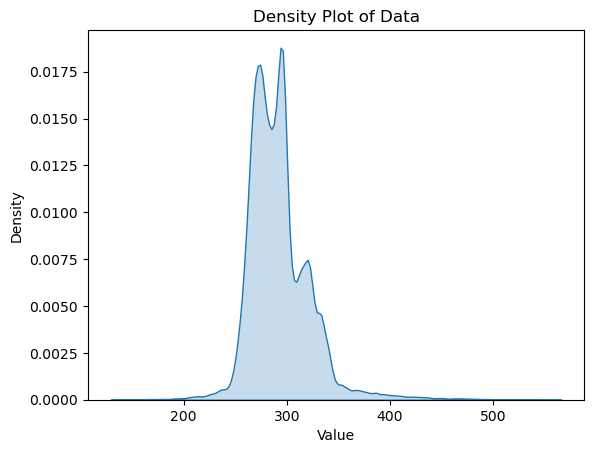

In [5]:
# import seaborn as sns
# sns.boxplot(data=Time)
import seaborn as sns

# 绘制密度图
sns.kdeplot(data['Mid_Price'], shade=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Data')
plt.show()

In [6]:
from scipy import stats
statistic, pvalue = stats.normaltest(data['level5_Ask_Price'])

# Print the test statistic and p-value
print("Test statistic:", statistic)
print("p-value:", pvalue)

# Interpret the p-value
alpha = 0.05
if pvalue < alpha:
    print("The sample does not come from a normal distribution.")
else:
    print("The sample comes from a normal distribution.")

Test statistic: 205436.72995961324
p-value: 0.0
The sample does not come from a normal distribution.


In [7]:
from sklearn.preprocessing import StandardScaler
feature_scaler=StandardScaler()
X_train=feature_scaler.fit_transform(X_train)
X_test=feature_scaler.transform(X_test)

target_scaler=StandardScaler()
y_train=target_scaler.fit_transform(y_train)
y_test=target_scaler.transform(y_test)

In [8]:
def reshape_to_batches(a, batch_size):
    #pad if the length is not divisible by the batch_size
    batch_num = np.ceil(a.shape[0] / float(batch_size))
    modulo = batch_num * batch_size - a.shape[0]
    if modulo != 0:
        pad = np.zeros((int(modulo), a.shape[1]))
        a = np.vstack((a, pad))
    return np.array(np.split(a, batch_num))

In [9]:
batch_size = 30 #30 is about 165 minute (5.5min per ts x 30), tried 15 and a few other values too but 30 seems to be the best

X_train_batch = reshape_to_batches(X_train, batch_size)
y_train_batch = reshape_to_batches(y_train, batch_size)
print(X_train_batch.shape, y_train_batch.shape)

X_test_batch = reshape_to_batches(X_test, batch_size)
y_test_batch = reshape_to_batches(y_test, batch_size)
print(X_test_batch.shape, y_test_batch.shape)

(23833, 30, 26) (23833, 30, 1)
(5959, 30, 26) (5959, 30, 1)


In [10]:
# don't count the Mid-price in
def df_to_time_step(df_x,df_y, window_size=30):
  # df_x_np = df_x.to_numpy()
  # df_y_np = df_y.to_numpy()
  X = []
  y = []
  for i in range(len(df_x)-window_size):
    row = [r for r in df_x[i:i+window_size]] # the whole row
    X.append(row)
    label = df_y[i+window_size] # temperature
    y.append(label)
  return np.array(X), np.array(y)

In [11]:
timestep=100
X_train_step, y_train_step=df_to_time_step(X_train, y_train,timestep)
X_test_step, y_test_step= df_to_time_step(X_test,y_test,timestep)
print(X_train_step.shape, y_train_step.shape)
print(X_test_step.shape, y_test_step.shape)

(714870, 100, 26) (714870, 1)
(178643, 100, 26) (178643, 1)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [16]:
#Allows the network to accept batches of any size as input when predicting
# Make the model
model1 = Sequential()
lstm=LSTM(32,activation='tanh',recurrent_activation='hard_sigmoid', use_bias=True,
            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
            bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None,
            recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0,
            recurrent_dropout=0.0, implementation=1, return_sequences=True, return_state=False,
            go_backwards=False, stateful=False, unroll=False, input_shape=(batch_size, 26))
model1.add(lstm)
model1.add(TimeDistributed(Dense(1, activation='linear')))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 32)            7552      
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 1)            33        
 tributed)                                                       
                                                                 
Total params: 7,585
Trainable params: 7,585
Non-trainable params: 0
_________________________________________________________________


In [17]:
model1.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [18]:
model1_fit=model1.fit(X_train_batch, y_train_batch, epochs=500, batch_size=100)

Epoch 1/500
239/239 [==============================] - 8s 24ms/step - loss: 0.0879 - accuracy: 2.7972e-05
Epoch 2/500
239/239 [==============================] - 6s 24ms/step - loss: 0.0033 - accuracy: 2.7972e-05
Epoch 3/500
239/239 [==============================] - 6s 24ms/step - loss: 0.0015 - accuracy: 2.7972e-05
Epoch 4/500
239/239 [==============================] - 6s 24ms/step - loss: 0.0011 - accuracy: 2.7972e-05
Epoch 5/500
239/239 [==============================] - 6s 24ms/step - loss: 9.0975e-04 - accuracy: 2.7972e-05
Epoch 6/500
239/239 [==============================] - 6s 24ms/step - loss: 8.1098e-04 - accuracy: 2.7972e-05
Epoch 7/500
239/239 [==============================] - 6s 24ms/step - loss: 7.5494e-04 - accuracy: 2.7972e-05
Epoch 8/500
239/239 [==============================] - 6s 24ms/step - loss: 6.7488e-04 - accuracy: 2.7972e-05
Epoch 9/500
239/239 [==============================] - 6s 25ms/step - loss: 6.3072e-04 - accuracy: 2.7972e-05
Epoch 10/500
239/239 [====

239/239 [==============================] - 6s 24ms/step - loss: 2.2182e-04 - accuracy: 2.7972e-05
Epoch 76/500
239/239 [==============================] - 6s 24ms/step - loss: 2.1576e-04 - accuracy: 2.7972e-05
Epoch 77/500
239/239 [==============================] - 6s 24ms/step - loss: 2.2172e-04 - accuracy: 2.7972e-05
Epoch 78/500
239/239 [==============================] - 6s 24ms/step - loss: 2.1349e-04 - accuracy: 2.7972e-05
Epoch 79/500
239/239 [==============================] - 6s 24ms/step - loss: 2.1530e-04 - accuracy: 2.7972e-05
Epoch 80/500
239/239 [==============================] - 6s 24ms/step - loss: 2.1138e-04 - accuracy: 2.7972e-05
Epoch 81/500
239/239 [==============================] - 6s 24ms/step - loss: 2.0389e-04 - accuracy: 2.7972e-05
Epoch 82/500
239/239 [==============================] - 6s 27ms/step - loss: 2.1196e-04 - accuracy: 2.7972e-05
Epoch 83/500
239/239 [==============================] - 6s 24ms/step - loss: 2.1206e-04 - accuracy: 2.7972e-05
Epoch 84/500
2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



239/239 [==============================] - 6s 24ms/step - loss: 1.4552e-04 - accuracy: 2.7972e-05
Epoch 146/500
239/239 [==============================] - 6s 24ms/step - loss: 1.4852e-04 - accuracy: 2.7972e-05
Epoch 147/500
239/239 [==============================] - 6s 24ms/step - loss: 1.4310e-04 - accuracy: 2.7972e-05
Epoch 148/500
239/239 [==============================] - 6s 24ms/step - loss: 1.3948e-04 - accuracy: 2.7972e-05
Epoch 149/500
239/239 [==============================] - 6s 24ms/step - loss: 1.3925e-04 - accuracy: 2.7972e-05
Epoch 150/500
239/239 [==============================] - 6s 24ms/step - loss: 1.3933e-04 - accuracy: 2.7972e-05
Epoch 151/500
239/239 [==============================] - 6s 24ms/step - loss: 1.4242e-04 - accuracy: 2.7972e-05
Epoch 152/500
239/239 [==============================] - 6s 24ms/step - loss: 1.4288e-04 - accuracy: 2.7972e-05
Epoch 153/500
239/239 [==============================] - 6s 26ms/step - loss: 1.3786e-04 - accuracy: 2.7972e-05
Epoch 

239/239 [==============================] - 6s 24ms/step - loss: 1.0822e-04 - accuracy: 2.7972e-05
Epoch 219/500
239/239 [==============================] - 6s 24ms/step - loss: 1.0936e-04 - accuracy: 2.7972e-05
Epoch 220/500
239/239 [==============================] - 6s 24ms/step - loss: 1.0585e-04 - accuracy: 2.7972e-05
Epoch 221/500
239/239 [==============================] - 6s 24ms/step - loss: 1.1083e-04 - accuracy: 2.7972e-05
Epoch 222/500
239/239 [==============================] - 6s 24ms/step - loss: 1.1053e-04 - accuracy: 2.7972e-05
Epoch 223/500
239/239 [==============================] - 6s 24ms/step - loss: 1.0477e-04 - accuracy: 2.7972e-05
Epoch 224/500
239/239 [==============================] - 6s 24ms/step - loss: 1.0299e-04 - accuracy: 2.7972e-05
Epoch 225/500
239/239 [==============================] - 6s 24ms/step - loss: 1.0685e-04 - accuracy: 2.7972e-05
Epoch 226/500
239/239 [==============================] - 6s 24ms/step - loss: 1.0330e-04 - accuracy: 2.7972e-05
Epoch 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



239/239 [==============================] - 6s 26ms/step - loss: 7.9868e-05 - accuracy: 2.7972e-05
Epoch 339/500
239/239 [==============================] - 6s 25ms/step - loss: 8.3254e-05 - accuracy: 2.7972e-05
Epoch 340/500
239/239 [==============================] - 6s 25ms/step - loss: 8.0160e-05 - accuracy: 2.7972e-05
Epoch 341/500
239/239 [==============================] - 6s 25ms/step - loss: 8.0727e-05 - accuracy: 2.7972e-05
Epoch 342/500
239/239 [==============================] - 6s 25ms/step - loss: 7.8097e-05 - accuracy: 2.7972e-05
Epoch 343/500
239/239 [==============================] - 6s 25ms/step - loss: 8.2831e-05 - accuracy: 2.7972e-05
Epoch 344/500
239/239 [==============================] - 6s 25ms/step - loss: 7.8389e-05 - accuracy: 2.7972e-05
Epoch 345/500
239/239 [==============================] - 6s 25ms/step - loss: 7.9196e-05 - accuracy: 2.7972e-05
Epoch 346/500
239/239 [==============================] - 6s 25ms/step - loss: 8.1849e-05 - accuracy: 2.7972e-05
Epoch 

239/239 [==============================] - 14s 58ms/step - loss: 7.1295e-05 - accuracy: 2.7972e-05
Epoch 416/500
239/239 [==============================] - 9s 38ms/step - loss: 6.9541e-05 - accuracy: 2.7972e-05
Epoch 417/500
239/239 [==============================] - 6s 26ms/step - loss: 7.2906e-05 - accuracy: 2.7972e-05
Epoch 418/500
239/239 [==============================] - 6s 25ms/step - loss: 7.0145e-05 - accuracy: 2.7972e-05
Epoch 419/500
239/239 [==============================] - 6s 25ms/step - loss: 7.1340e-05 - accuracy: 2.7972e-05
Epoch 420/500
239/239 [==============================] - 6s 25ms/step - loss: 6.9629e-05 - accuracy: 2.7972e-05
Epoch 421/500
239/239 [==============================] - 6s 25ms/step - loss: 7.2006e-05 - accuracy: 2.7972e-05
Epoch 422/500
239/239 [==============================] - 6s 25ms/step - loss: 7.4625e-05 - accuracy: 2.7972e-05
Epoch 423/500
239/239 [==============================] - 6s 25ms/step - loss: 6.6174e-05 - accuracy: 2.7972e-05
Epoch

In [19]:
# Predict the values
y_pred=model1.predict(X_test_batch)
print(y_pred.shape)

187/187 [==============================] - 2s 9ms/step
(5959, 30, 1)


In [20]:
#linear
from sklearn.metrics import mean_absolute_percentage_error
y_predict=y_pred.flatten()
y_predict_t=y_predict.reshape(-1,1)

y_test_t=y_test_batch.flatten()
y_test_t1=y_test_t.reshape(-1,1)
y_predict_o=target_scaler.inverse_transform(y_predict_t)
y_test_o=target_scaler.inverse_transform(y_test_t1)
y_predict_o=y_predict_o.flatten()
y_test_o=y_test_o.flatten()
print(mean_absolute_error(y_test_o,y_predict_o))
print(mean_squared_error(y_test_o,y_predict_o))
print(mean_absolute_percentage_error(y_test_o,y_predict_o))
test_results = pd.DataFrame(data={'Test Predictions':y_predict_o, 'Actuals':y_test_o})
test_results

0.2143662073069077
0.19438347123566588
0.0007621931357628505


,Test Predictions,Actuals
0,310.206848,310.000001
1,310.233002,310.000001
2,310.671143,310.000001
3,372.845795,373.000001
4,372.953186,373.000001
...,...,...
178765,294.094635,294.162378
178766,294.094635,294.162378
178767,294.094635,294.162378
178768,294.094635,294.162378


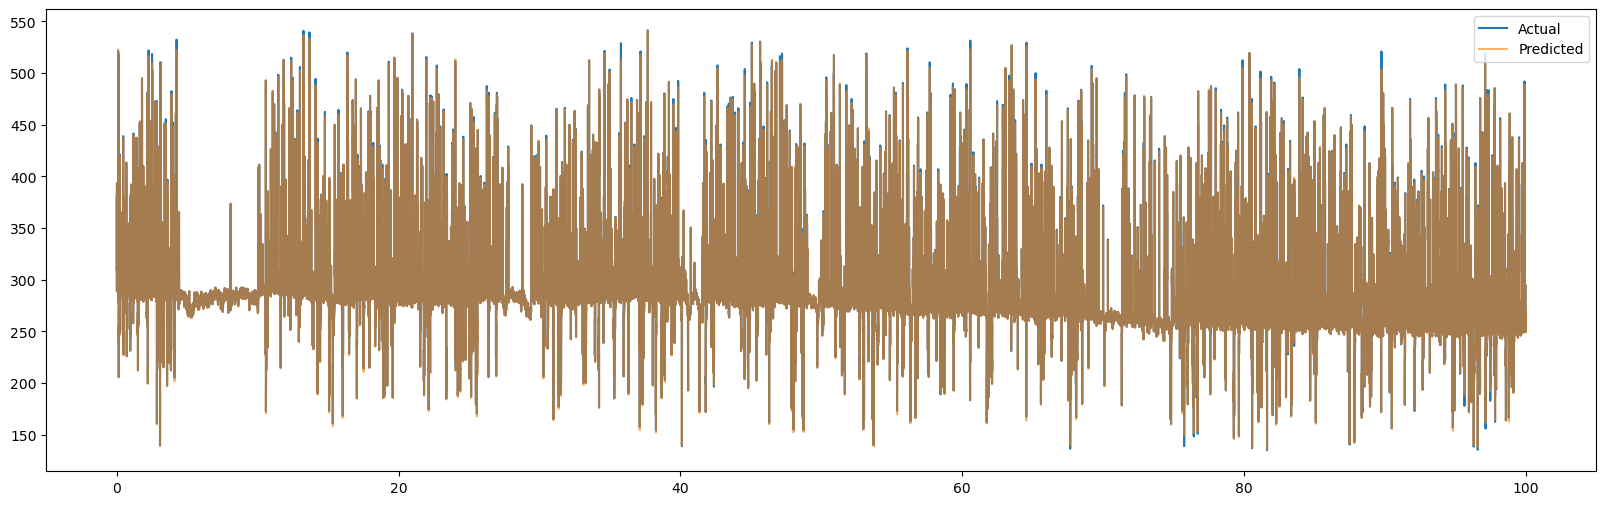

In [21]:
plt.figure(figsize=(20,6))
plt.plot(np.linspace(0, 100, len(y_test_o)), y_test_o, label='Actual')
plt.plot(np.linspace(0, 100, len(y_predict_o)), y_predict_o, alpha=0.6, label='Predicted')
plt.legend()

In [22]:
model2 = Sequential()
lstm=LSTM(32,activation='tanh',recurrent_activation='hard_sigmoid', use_bias=True,
            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
            bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None,
            recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0,
            recurrent_dropout=0.0, implementation=1, return_sequences=True, return_state=False,
            go_backwards=False, stateful=False, unroll=False, input_shape=(batch_size,26))
model2.add(lstm)
# use relu
model2.add(TimeDistributed(Dense(1, activation='relu')))
model2.summary()

model2.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['accuracy'])

# Fit the model
model2.fit(X_train_batch, y_train_batch, epochs=500, batch_size=100)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 32)            7552      
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 1)            33        
 tributed)                                                       
                                                                 
Total params: 7,585
Trainable params: 7,585
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
239/239 [==============================] - 9s 24ms/step - loss: 0.3918 - accuracy: 2.7972e-05
Epoch 2/500
239/239 [==============================] - 6s 24ms/step - loss: 0.3397 - accuracy: 2.7972e-05
Epoch 3/500
239/239 [==============================] - 6s 24ms/step - loss: 0.3384 - accuracy: 2.7972e-05
Epoch 4/500
239/239 [==============================] - 6s 24ms/s

239/239 [==============================] - 6s 26ms/step - loss: 0.3376 - accuracy: 2.7972e-05
Epoch 71/500
239/239 [==============================] - 7s 27ms/step - loss: 0.3376 - accuracy: 2.7972e-05
Epoch 72/500
239/239 [==============================] - 6s 27ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 73/500
239/239 [==============================] - 6s 25ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 74/500
239/239 [==============================] - 6s 25ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 75/500
239/239 [==============================] - 6s 25ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 76/500
239/239 [==============================] - 7s 30ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 77/500
239/239 [==============================] - 7s 28ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 78/500
239/239 [==============================] - 7s 30ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 79/500
239/239 [============================

239/239 [==============================] - 7s 30ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 158/500
239/239 [==============================] - 7s 29ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 159/500
239/239 [==============================] - 7s 29ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 160/500
239/239 [==============================] - 7s 30ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 161/500
239/239 [==============================] - 7s 30ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 162/500
239/239 [==============================] - 7s 29ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 163/500
239/239 [==============================] - 7s 29ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 164/500
239/239 [==============================] - 7s 30ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 165/500
239/239 [==============================] - 7s 30ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 166/500
239/239 [===================

Epoch 233/500
239/239 [==============================] - 7s 30ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 234/500
239/239 [==============================] - 8s 31ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 235/500
239/239 [==============================] - 8s 32ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 236/500
239/239 [==============================] - 7s 29ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 237/500
239/239 [==============================] - 7s 31ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 238/500
239/239 [==============================] - 7s 30ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 239/500
239/239 [==============================] - 7s 31ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 240/500
239/239 [==============================] - 7s 29ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 241/500
239/239 [==============================] - 7s 28ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 242/500
239/239 [=====

239/239 [==============================] - 6s 24ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 309/500
239/239 [==============================] - 6s 24ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 310/500
239/239 [==============================] - 6s 24ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 311/500
239/239 [==============================] - 6s 23ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 312/500
239/239 [==============================] - 6s 23ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 313/500
239/239 [==============================] - 6s 23ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 314/500
239/239 [==============================] - 6s 23ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 315/500
239/239 [==============================] - 6s 24ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 316/500
239/239 [==============================] - 6s 24ms/step - loss: 0.3375 - accuracy: 2.7972e-05
Epoch 317/500
239/239 [===================

Epoch 397/500
239/239 [==============================] - 6s 23ms/step - loss: 0.3374 - accuracy: 2.7972e-05
Epoch 398/500
239/239 [==============================] - 6s 23ms/step - loss: 0.3374 - accuracy: 2.7972e-05
Epoch 399/500
239/239 [==============================] - 6s 23ms/step - loss: 0.3374 - accuracy: 2.7972e-05
Epoch 400/500
239/239 [==============================] - 6s 23ms/step - loss: 0.3374 - accuracy: 2.7972e-05
Epoch 401/500
239/239 [==============================] - 6s 23ms/step - loss: 0.3374 - accuracy: 2.7972e-05
Epoch 402/500
239/239 [==============================] - 6s 23ms/step - loss: 0.3374 - accuracy: 2.7972e-05
Epoch 403/500
239/239 [==============================] - 6s 23ms/step - loss: 0.3374 - accuracy: 2.7972e-05
Epoch 404/500
239/239 [==============================] - 6s 23ms/step - loss: 0.3374 - accuracy: 2.7972e-05
Epoch 405/500
103/239 [===========>..................] - ETA: 3s - loss: 0.3327 - accuracy: 0.0000e+00

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



239/239 [==============================] - 6s 24ms/step - loss: 0.3374 - accuracy: 2.7972e-05
Epoch 432/500
239/239 [==============================] - 6s 24ms/step - loss: 0.3374 - accuracy: 2.7972e-05
Epoch 433/500
239/239 [==============================] - 6s 24ms/step - loss: 0.3374 - accuracy: 2.7972e-05
Epoch 434/500
239/239 [==============================] - 6s 24ms/step - loss: 0.3374 - accuracy: 2.7972e-05
Epoch 435/500
239/239 [==============================] - 6s 24ms/step - loss: 0.3374 - accuracy: 2.7972e-05
Epoch 436/500
239/239 [==============================] - 6s 24ms/step - loss: 0.3374 - accuracy: 2.7972e-05
Epoch 437/500
239/239 [==============================] - 6s 23ms/step - loss: 0.3374 - accuracy: 2.7972e-05
Epoch 438/500
239/239 [==============================] - 6s 24ms/step - loss: 0.3374 - accuracy: 2.7972e-05
Epoch 439/500
239/239 [==============================] - 6s 23ms/step - loss: 0.3374 - accuracy: 2.7972e-05
Epoch 440/500
239/239 [===================

In [23]:
#relu
y_pred = model2.predict(X_test_batch)
print(y_pred.shape)

187/187 [==============================] - 2s 10ms/step
(5959, 30, 1)


In [24]:
from sklearn.metrics import mean_absolute_percentage_error
y_predict=y_pred.flatten()
y_predict_t=y_predict.reshape(-1,1)

y_test_t=y_test_batch.flatten()
y_test_t1=y_test_t.reshape(-1,1)
y_predict_o=target_scaler.inverse_transform(y_predict_t)
y_test_o=target_scaler.inverse_transform(y_test_t1)
y_predict_o=y_predict_o.flatten()
y_test_o=y_test_o.flatten()
print(mean_absolute_error(y_test_o,y_predict_o))
print(mean_squared_error(y_test_o,y_predict_o))
print(mean_absolute_percentage_error(y_test_o,y_predict_o))
test_results = pd.DataFrame(data={'Test Predictions':y_predict_o, 'Actuals':y_test_o})
test_results

18.66188774337509
723.4027999766394
0.07389452805354134


,Test Predictions,Actuals
0,310.065765,310.000001
1,310.012451,310.000001
2,309.927399,310.000001
3,372.880157,373.000001
4,373.490234,373.000001
...,...,...
178765,294.162384,294.162378
178766,294.162384,294.162378
178767,294.162384,294.162378
178768,294.162384,294.162378


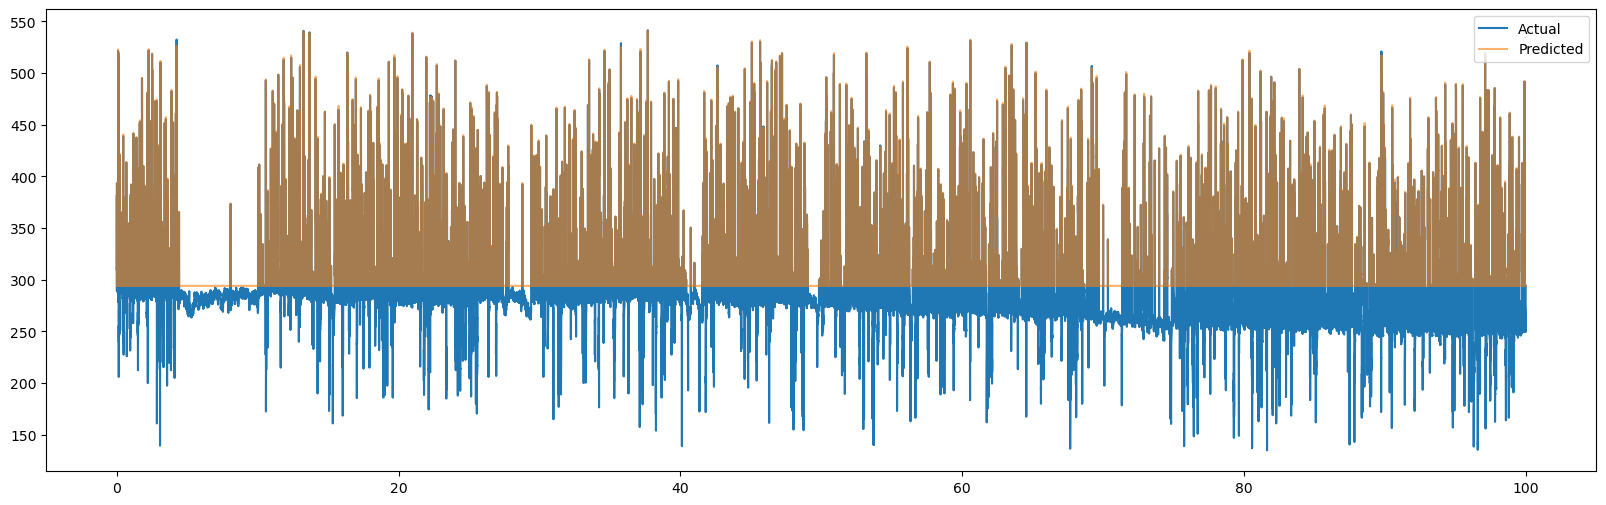

In [25]:
plt.figure(figsize=(20,6))
plt.plot(np.linspace(0, 100, len(y_test_o)), y_test_o, label='Actual')
plt.plot(np.linspace(0, 100, len(y_predict_o)), y_predict_o, alpha=0.6, label='Predicted')
plt.legend()